# Quick start: Forecasting with synthetic data

In this notebook, we train Treeffuser on synthethic data and then visualize both the original and model-generated samples to explore how well Treeffuser captures the underlying distribution of the data.

## Getting started

We first install `treeffuser` and import the relevant libraries.

In [9]:
%%capture
!pip install treeffuser

import matplotlib.pyplot as plt
import numpy as np

from treeffuser import Treeffuser

We simulate a non-linear, bimodal response of $y$ given $x$, where the two modes follow two different response functions: one is a sine function and the other is a cosine function over $x$.

In [10]:
seed = 0  # fixing the random seed for reproducibility
n = 5000  # number of data points

rng = np.random.default_rng(seed=seed)
x = rng.uniform(0, 2 * np.pi, size=n)  # x values in the range [0, 2π)
z = rng.integers(0, 2, size=n)  # response function assignments

y = z * np.sin(x - np.pi / 2) + (1 - z) * np.cos(x)

We also introduce heteroscedastic, fat-tailed noise from a Laplace distribution, meaning the variability of $y$ increases with $x$ and may result in large outliers.

In [11]:
y += rng.laplace(scale=x / 30, size=n)

## Fitting Treffuser and producing samples

Fitting Treeffuser and generating samples is very simple, as Treeffuser adheres to the `sklearn.base.BaseEstimator` class. Fitting amounts to initializing the model and calling the `fit` method, just like any `scikit-learn` estimator. Samples are then generated using the `sample` method.

In [12]:
model = Treeffuser(sde_initialize_from_data=True, seed=seed)
model.fit(x, y)

y_samples = model.sample(x, n_samples=1, seed=seed, verbose=True)

100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


## Plotting the samples

We create a scatter plot to visualize both the original data and the samples produced by Treeffuser. The samples closely reflect the underlying response distributions that generated the data.

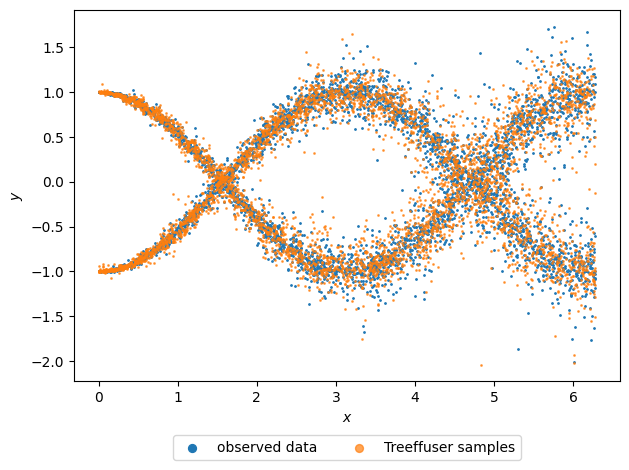

In [13]:
plt.scatter(x, y, s=1, label="observed data")
plt.scatter(x, y_samples[0, :], s=1, alpha=0.7, label="Treeffuser samples")

plt.xlabel("$x$")
plt.ylabel("$y$")

legend = plt.legend(loc="upper center", scatterpoints=1, bbox_to_anchor=(0.5, -0.125), ncol=2)
for legend_handle in legend.legend_handles:
    legend_handle.set_sizes([32])  # change marker size for legend

plt.tight_layout()

The samples generated by Treeffuser can be used to compute any downstream estimates of interest.

In [14]:
x = np.array(np.pi).reshape((1, 1))
y_samples = model.sample(x, n_samples=100, verbose=True)  # y_samples.shape[0] is 100

# Estimate downstream quantities of interest
y_mean = y_samples.mean(axis=0)  # conditional mean for each x
y_std = y_samples.std(axis=0)  # conditional std for each x

print(f"Mean of the samples: {y_mean}")
print(f"Standard deviation of the samples: {y_std} ")

100%|██████████| 100/100 [00:00<00:00, 439.38it/s]

Mean of the samples: [-0.02825952]
Standard deviation of the samples: [0.99196348] 


For convenience, we also provide a class Samples that can estimate standard quantities.

In [15]:
from treeffuser.samples import Samples

y_samples = Samples(y_samples)
y_mean = y_samples.sample_mean()  # same as before
y_std = y_samples.sample_std()  # same as before
y_quantiles = y_samples.sample_quantile(q=[0.05, 0.95])  # conditional quantiles for each x

print(f"Mean of the samples: {y_mean}")
print(f"Standard deviation of the samples: {y_std} ")
print(f"5th and 95th quantiles of the samples: {y_quantiles.reshape(-1)}")

Mean of the samples: [-0.02825952]
Standard deviation of the samples: [0.99196348] 
5th and 95th quantiles of the samples: [-1.24177638  1.14385214]
